In [69]:
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingClassifier

from xgboost import XGBClassifier

In [70]:
x_train = pd.read_csv('x_train_openSmile_emobase.csv')
y_train = pd.read_csv('y_train_openSmile_emobase.csv')
x_test = pd.read_csv('x_test_openSmile_emobase.csv')
y_test = pd.read_csv('y_test_openSmile_emobase.csv')

y_test['emotion'] = np.where(y_test['emotion'] == 'sad', 1, 0)
y_train['emotion'] = np.where(y_train['emotion'] == 'sad', 1, 0)

In [71]:
etc = ExtraTreesClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

etc.fit(x_train, y_train["emotion"])

importances = etc.feature_importances_

sorted_importances = np.sort(importances)[::-1]
cumulative_importances = np.cumsum(sorted_importances)
threshold_index = np.searchsorted(cumulative_importances, 0.75)
threshold_value = sorted_importances[threshold_index]

selector_model = SelectFromModel(etc, threshold=threshold_value, prefit=True)

selected_features = x_train.columns[selector_model.get_support()]


Classification Report:
              precision    recall  f1-score   support

     not sad       0.93      0.96      0.94       533
         sad       0.74      0.62      0.67       104

    accuracy                           0.90       637
   macro avg       0.83      0.79      0.81       637
weighted avg       0.90      0.90      0.90       637



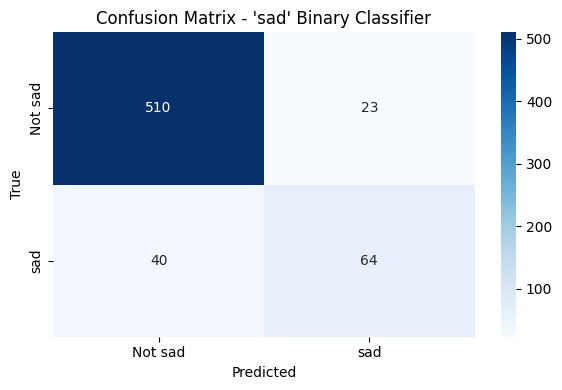

In [72]:
selector = ColumnTransformer(
  [
    ("pick_sad", "passthrough", selected_features)
  ],
  remainder="drop"
)

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    alpha=1e-3,
    learning_rate_init=1e-3,
    max_iter=1000,
    random_state=42,
    verbose=False
)

sad_pipeline = Pipeline([
    ("select", selector),
    ("mlp", mlp)
])

sad_pipeline.fit(x_train, y_train["emotion"])
y_pred = sad_pipeline.predict(x_test)


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['not sad', 'sad']))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=[f"Not sad", "sad"],
    yticklabels=[f"Not sad", "sad"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - 'sad' Binary Classifier")
plt.tight_layout()
plt.show()

In [73]:
joblib.dump(sad_pipeline, "sad_mlp_model.pkl")

['sad_mlp_model.pkl']